# TensorFlow1 推理

下面以模型 [resnet_v2_50](http://download.tensorflow.org/models/resnet_v2_50_2017_04_14.tar.gz) 为例展示。

需要克隆项目 [models](https://github.com/tensorflow/models)，然后执行如下操作。

In [1]:
import tensorflow as tf
try:
    tf1 = tf.compat.v1
    tf1.disable_v2_behavior()
except (ImportError, AttributeError):
    tf1 = tf

2023-06-13 18:43:35.590406: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-13 18:43:35.651460: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-13 18:43:35.652767: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-13 18:43:36.560058: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Instructions for updating:
non-resource variables are not supported in the long term


切换到 `models/research/slim` 目录下：

In [2]:
%cd /media/pc/data/lxw/ai/tasks/models/research/slim

/media/pc/data/lxw/ai/tasks/models/research/slim


定义缓存目录：

In [3]:
checkpoints_dir = '/tmp/checkpoints'

下载权重文件：

In [4]:
from datasets import dataset_utils

url = "http://download.tensorflow.org/models/resnet_v2_50_2017_04_14.tar.gz"

if not tf1.gfile.Exists(checkpoints_dir):
    tf1.gfile.MakeDirs(checkpoints_dir)

dataset_utils.download_and_uncompress_tarball(url, checkpoints_dir)

>> Downloading resnet_v2_50_2017_04_14.tar.gz 100.0%
Successfully downloaded resnet_v2_50_2017_04_14.tar.gz 286441851 bytes.


定义模型并推理：

In [5]:
from PIL import Image
import numpy as np
from nets import resnet_v2
from preprocessing.preprocessing_factory import get_preprocessing
import tf_slim as slim

preprocessing = get_preprocessing("resnet_v2_50")
image_size = 224
path = '/media/pc/data/board/arria10/lxw/data/test/cat.png' # 将要预测的图片路径

with Image.open(path) as im:
    if im.mode != "RGB":
        im.convert("RGB")
    image = np.asarray(im)


with tf1.Graph().as_default():
    image = tf.constant(image)
    processed_image = preprocessing(image, image_size, image_size)
    processed_images  = tf.expand_dims(processed_image/256, 0)
    
    # 创建模型时，使用默认的参数范围（arg scope）来配置批归一化（batch norm）参数。
    with slim.arg_scope(resnet_v2.resnet_arg_scope()):
        logits, _ = resnet_v2.resnet_v2_50(processed_images, num_classes=1001,
                                           global_pool=True,
                                           is_training=False)
    probabilities = tf.nn.softmax(logits)
    
    init_fn = slim.assign_from_checkpoint_fn(
        f'{checkpoints_dir}/resnet_v2_50.ckpt',
        slim.get_model_variables('resnet_v2_50'))
    
    with tf1.Session() as sess:
        init_fn(sess)
        np_processed_image, probabilities = sess.run([processed_image, probabilities])
        probabilities = probabilities[0, 0:]
        sorted_inds = [i[0] for i in sorted(enumerate(-probabilities), key=lambda x:x[1])]

Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use `tf.cast` instead.


/media/pc/data/tmp/cache/conda/envs/tvmz/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


INFO:tensorflow:Restoring parameters from /tmp/checkpoints/resnet_v2_50.ckpt


2023-06-13 18:44:41.498624: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-06-13 18:44:41.532260: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled


打印标签信息：

In [6]:
from github import Github


g = Github(user_agent="xinetzone")
repo = g.get_repo("tensorflow/models")
label_content = repo.get_contents("research/slim/datasets/imagenet_lsvrc_2015_synsets.txt")
imagenet_labels = label_content.decoded_content.decode().split()
assert len(imagenet_labels) == 1000
metadata = repo.get_contents("research/slim/datasets/imagenet_metadata.txt")
imagenet_metadata = metadata.decoded_content.decode().splitlines()
synset_to_human = {}
for metadata in imagenet_metadata:
    name, value = metadata.split("\t")
    synset_to_human[name] = value
name2id = {name: k+1 for k, name in enumerate(imagenet_labels)}

In [7]:
topk = 5
for prob, sorted_ind in zip(probabilities[:topk], sorted_inds[:topk]):
    label = synset_to_human[imagenet_labels[sorted_ind-1]]
    print(f"{sorted_ind-1}: {label.ljust(20)}\t{prob}")

282: tiger cat           	6.913422794241342e-07
285: Egyptian cat        	2.1831299079622113e-07
281: tabby, tabby cat    	1.9797682853095466e-06
278: kit fox, Vulpes macrotis	3.303630080608855e-08
277: red fox, Vulpes vulpes	1.9624657454642147e-07


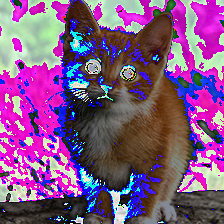

In [8]:
Image.fromarray(np_processed_image.astype(np.uint8))